In [197]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import math

In [198]:
PAPERS_CSV = "papers_and_authors.csv"
EDGES_CSV = "edges.csv"

papers_df = pd.read_csv(PAPERS_CSV)
edges_df = pd.read_csv(EDGES_CSV)
papers_df.columns = [c.strip() for c in papers_df.columns]
edges_df.columns = [c.strip() for c in edges_df.columns]

# Build Citation Graph
G = nx.DiGraph()
for _, row in papers_df.iterrows():
    paper_id = str(row["paper_id"]).strip()
    title = str(row["title"]).strip()
    # Handling year field 
    year_val = row["year"]
    if pd.isna(year_val):
        year = 0
    else:
        try:
            # Convert float like 2017.0 → 2017
            year = int(float(year_val))
        except ValueError:
            year = 0
    authors = str(row["authors"]).strip()
    G.add_node(paper_id, title=title, year=year, authors=authors)


for _, row in edges_df.iterrows():
    source = str(row["source"]).strip()
    target = str(row["target"]).strip()
    if source in G.nodes and target in G.nodes:
        G.add_edge(source , target)

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph built with 200 nodes and 598 edges


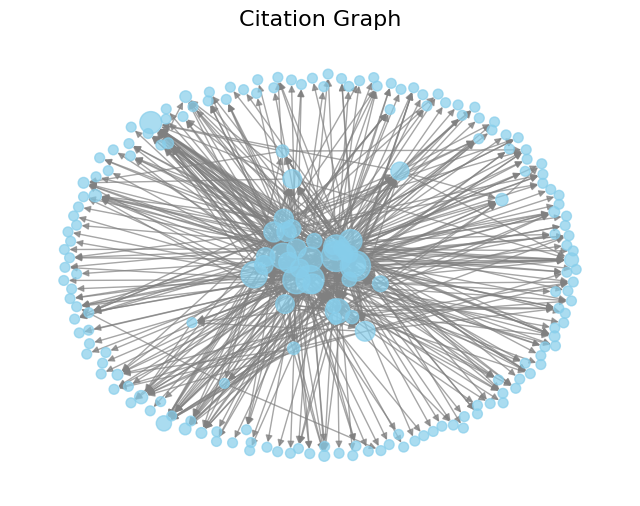

In [199]:
# node size depends on degree (for better visualization)
node_sizes = [max(50, 10 * G.degree(n)) for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=0.5, iterations=100)

plt.figure(figsize=(8, 6))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,     
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7,
    arrowsize=10
)

plt.title("Citation Graph", fontsize=16)
plt.axis("off")
plt.show()

In [200]:
def Temporal_Weights(G, lambda_decay=0.1):
    years = [data["year"] for _, data in G.nodes(data=True) if data.get("year", 0) > 0]
    Y_max = max(years) if years else 2025
    temporal_weights = {}
    for n, data in G.nodes(data=True):
        y = data.get("year" , Y_max)
        w = math.exp(-lambda_decay * (Y_max - y))
        temporal_weights[n] = w
    return temporal_weights

In [201]:
def PageRank(G, damping_factor=0.85, temporal_decay= 0.1, tolerance=1e-6, max_iterations=1000):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    PR = {n : 1 / N for n in nodes}
    temporal_weights = Temporal_Weights(G,temporal_decay)
    out_degree = {n : G.out_degree(n) for n in nodes}
    differences = []

    for iter in range(max_iterations):
        PR_new = {}
        dangling_rank = sum(PR[n] for n in nodes if out_degree[n] == 0)

        for n in nodes:
            rank_sum = 0.0
            for m in G.predecessors(n):
                if out_degree[m] > 0:
                    rank_sum += (PR[m] / out_degree[m])
            rank_sum += dangling_rank / N
            PR_new[n] = (1 - damping_factor) * temporal_weights[n] + damping_factor * rank_sum

        diff = sum(abs(PR_new[n] - PR[n]) for n in nodes)
        differences.append(diff)
        PR = PR_new

        if diff < tolerance :
            print(f"PageRank converged after {iter + 1} iterations")
            break

    return PR , differences , iter + 1

In [202]:
def Analysis(G,damping_factor,temporal_decay):
    PR, Differences, iterations = PageRank(G,damping_factor,temporal_decay)
    plt.plot(np.arange(0, iterations), Differences)
    plt.xlabel("Iterations")
    plt.ylabel("Residual")
    plt.title(f"PageRank Convergence (α = {damping_factor} and λ = {temporal_decay})")
    plt.show()
    top_papers = sorted(PR.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 papers by Temporal PageRank (alpha = {damping_factor} and λ = {temporal_decay}):")
    for pid, score in top_papers:
        node = G.nodes[pid]
        print(f"{pid[:8]} ({node.get('year','NA')}) - {node.get('title','')[:60]}... | Score: {score:.4f}")

    top_nodes = [pid for pid, _ in top_papers]

    # --- Smaller base nodes ---
    node_sizes = [40 for _ in G.nodes()]      # small uniform nodes
    node_colors = ["skyblue" for _ in G.nodes()]   # light blue everywhere

    pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)

    plt.figure(figsize=(5, 5))

    # --- Draw base graph ---
    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color="gray",
        alpha=0.5,
        arrowsize=8,
    )

    # --- Now draw only the top nodes as circles with thick borders ---
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=top_nodes,
        node_size=200,
        node_color="white",              # white fill
        edgecolors="darkred",            # strong border
        linewidths=2.5,                  # border thickness
    )

    # --- Label only the top-10 papers ---
    for n in top_nodes:
        x, y = pos[n]
        plt.text(
            x,
            y + 0.025,
            G.nodes[n]["title"][:25] + "...",
            fontsize=9,
            color="darkred",
            ha="center",
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                alpha=0.7,
                edgecolor="darkred",
                boxstyle="round,pad=0.2"
            )
        )

    plt.title(
        f"Temporal PageRank (α={damping_factor}, λ={temporal_decay})",
        fontsize=10
    )
    plt.axis("off")
    plt.margins(0.05)
    plt.tight_layout()
    plt.savefig(f"Temporal_PageRank(α={damping_factor}_λ={temporal_decay}).png")
    plt.show()
        

##### Damping Factor = 0.85 (Weak Temporal Effect)

PageRank converged after 103 iterations


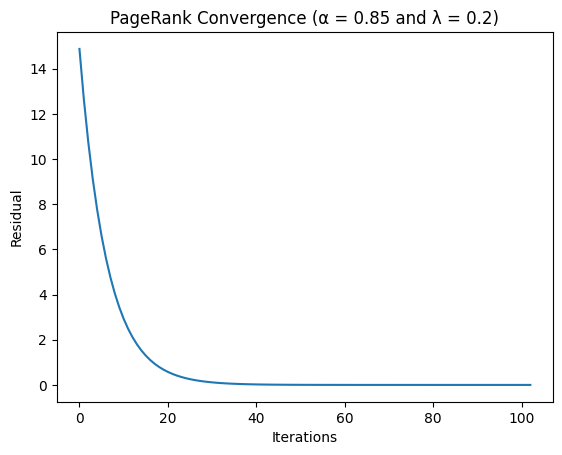


Top 10 papers by Temporal PageRank (alpha = 0.85 and λ = 0.2):
6c2b28f9 (2003) - A Neural Probabilistic Language Model... | Score: 1.3795
2e9d221c (1997) - Long Short-Term Memory... | Score: 1.3760
3449b650 (2011) - Torch7: A Matlab-like Environment for Machine Learning... | Score: 1.1681
abd1c342 (2012) - ImageNet classification with deep convolutional neural netwo... | Score: 1.1403
0b44fcbe (1993) - Building a Large Annotated Corpus of English: The Penn Treeb... | Score: 0.9761
944a1cfd (2013) - Recurrent Continuous Translation Models... | Score: 0.9615
855d0f72 (2012) - Theano: new features and speed improvements... | Score: 0.9352
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.9038
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.8918
6471fd1c (2013) - Generating Sequences With Recurrent Neural Networks... | Score: 0.8848


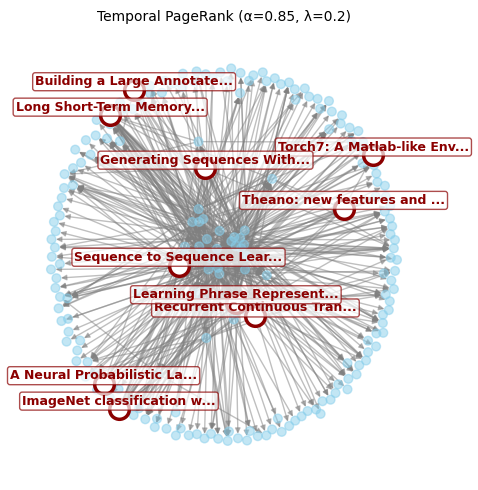

In [203]:
Analysis(G,damping_factor=0.85,temporal_decay=0.2)

##### Damping factor = 0.4 (Medium Temporal Bias)

PageRank converged after 21 iterations


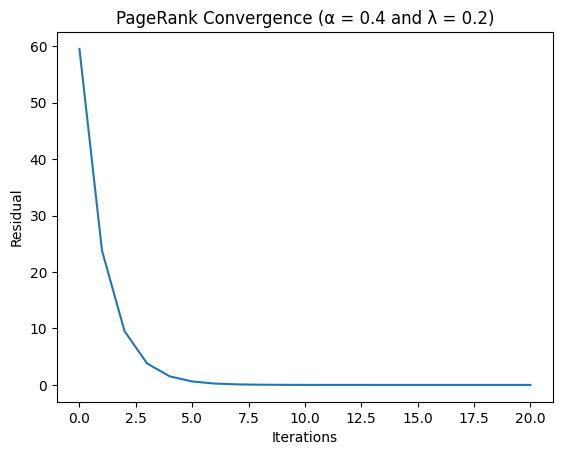


Top 10 papers by Temporal PageRank (alpha = 0.4 and λ = 0.2):
bcd857d7 (2018) - Published as a conference paper at ICLR 2018 S IMULATING A C... | Score: 0.7975
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.6869
abd1c342 (2012) - ImageNet classification with deep convolutional neural netwo... | Score: 0.6842
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.6766
510e2673 (2017) - Outrageously Large Neural Networks: The Sparsely-Gated Mixtu... | Score: 0.6739
fa72afa9 (2014) - Neural Machine Translation by Jointly Learning to Align and ... | Score: 0.6724
aab5002a (2017) - OpenNMT: Open-Source Toolkit for Neural Machine Translation... | Score: 0.6545
032274e5 (2017) - A Deep Reinforced Model for Abstractive Summarization... | Score: 0.6537
43428880 (2017) - Convolutional Sequence to Sequence Learning... | Score: 0.6537
4550a4c7 (2017) - Massive Exploration of Neural Machine Translation Architectu... | Score:

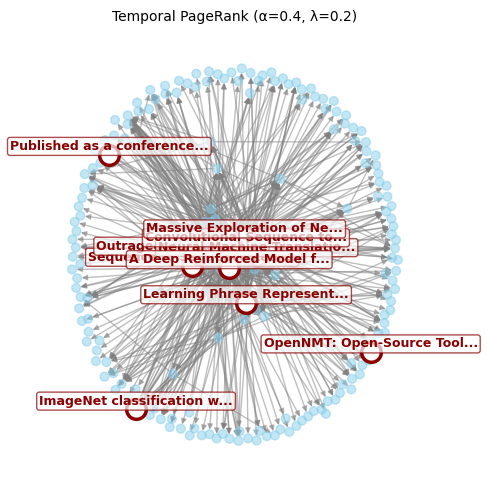

In [204]:
Analysis(G,damping_factor=0.4,temporal_decay=0.2)

##### Damping Factor = 0.2 (High Temporal Bias)

PageRank converged after 13 iterations


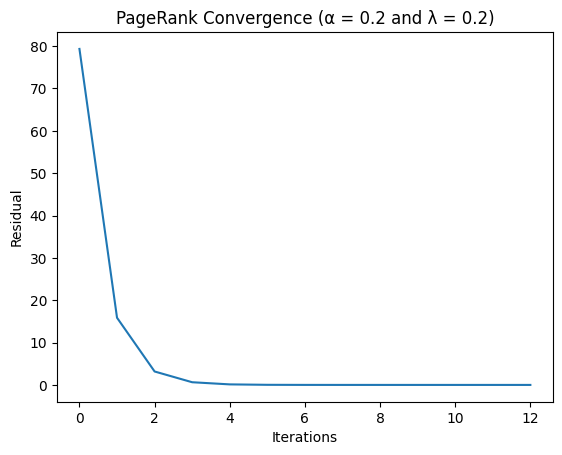


Top 10 papers by Temporal PageRank (alpha = 0.2 and λ = 0.2):
bcd857d7 (2018) - Published as a conference paper at ICLR 2018 S IMULATING A C... | Score: 0.9008
510e2673 (2017) - Outrageously Large Neural Networks: The Sparsely-Gated Mixtu... | Score: 0.7484
aab5002a (2017) - OpenNMT: Open-Source Toolkit for Neural Machine Translation... | Score: 0.7374
032274e5 (2017) - A Deep Reinforced Model for Abstractive Summarization... | Score: 0.7370
43428880 (2017) - Convolutional Sequence to Sequence Learning... | Score: 0.7370
4550a4c7 (2017) - Massive Exploration of Neural Machine Translation Architectu... | Score: 0.7370
204a4a70 (2017) - A Structured Self-attentive Sentence Embedding... | Score: 0.7370
79baf48b (2017) - Factorization tricks for LSTM networks... | Score: 0.7370
13d9323a (2017) - Structured Attention Networks... | Score: 0.7370
668db48c (2017) - Get To The Point: Summarization with Pointer-Generator Netwo... | Score: 0.7365


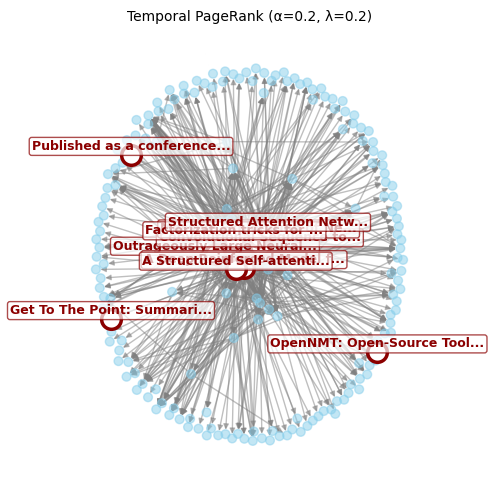

In [205]:
Analysis(G,damping_factor=0.2,temporal_decay=0.2)

PageRank converged after 100 iterations


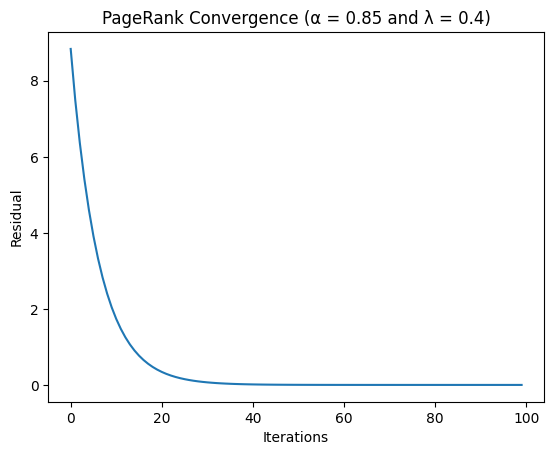


Top 10 papers by Temporal PageRank (alpha = 0.85 and λ = 0.4):
2e9d221c (1997) - Long Short-Term Memory... | Score: 0.8131
6c2b28f9 (2003) - A Neural Probabilistic Language Model... | Score: 0.8018
abd1c342 (2012) - ImageNet classification with deep convolutional neural netwo... | Score: 0.6638
3449b650 (2011) - Torch7: A Matlab-like Environment for Machine Learning... | Score: 0.6625
0b44fcbe (1993) - Building a Large Annotated Corpus of English: The Penn Treeb... | Score: 0.5725
944a1cfd (2013) - Recurrent Continuous Translation Models... | Score: 0.5565
855d0f72 (2012) - Theano: new features and speed improvements... | Score: 0.5323
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.5308
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.5234
d0be39ee (1994) - Learning long-term dependencies with gradient descent is dif... | Score: 0.5159


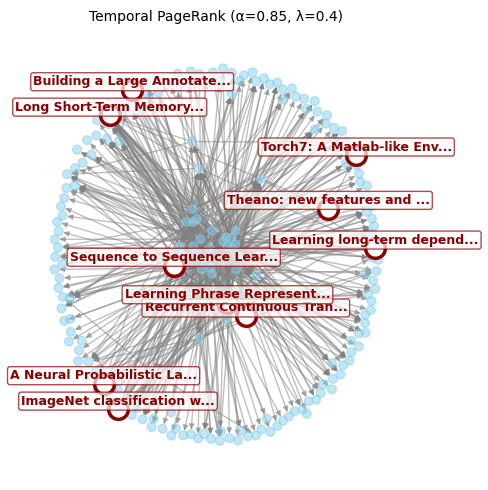

In [206]:
Analysis(G,damping_factor=0.85,temporal_decay=0.4)

PageRank converged after 97 iterations


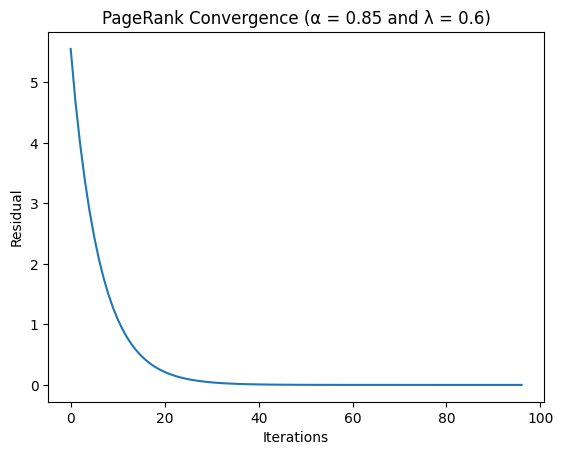


Top 10 papers by Temporal PageRank (alpha = 0.85 and λ = 0.6):
2e9d221c (1997) - Long Short-Term Memory... | Score: 0.5117
6c2b28f9 (2003) - A Neural Probabilistic Language Model... | Score: 0.4996
abd1c342 (2012) - ImageNet classification with deep convolutional neural netwo... | Score: 0.4133
3449b650 (2011) - Torch7: A Matlab-like Environment for Machine Learning... | Score: 0.4066
0b44fcbe (1993) - Building a Large Annotated Corpus of English: The Penn Treeb... | Score: 0.3594
944a1cfd (2013) - Recurrent Continuous Translation Models... | Score: 0.3430
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.3304
855d0f72 (2012) - Theano: new features and speed improvements... | Score: 0.3261
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.3252
d0be39ee (1994) - Learning long-term dependencies with gradient descent is dif... | Score: 0.3229


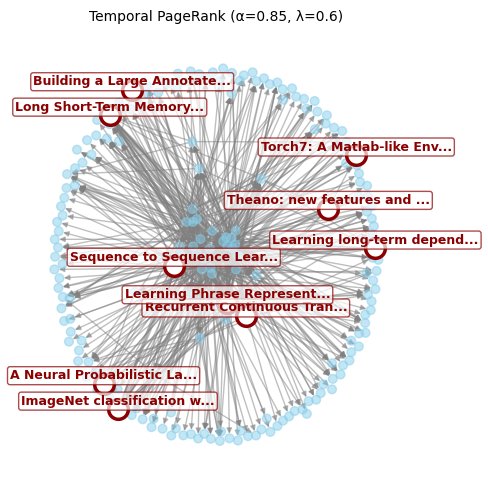

In [207]:
Analysis(G,damping_factor=0.85,temporal_decay=0.6)

PageRank converged after 94 iterations


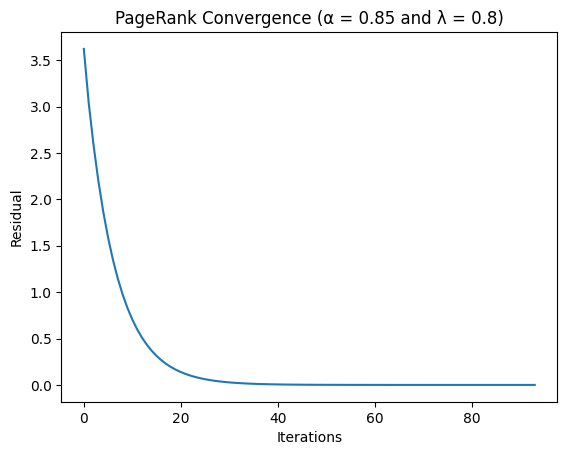


Top 10 papers by Temporal PageRank (alpha = 0.85 and λ = 0.8):
2e9d221c (1997) - Long Short-Term Memory... | Score: 0.3367
6c2b28f9 (2003) - A Neural Probabilistic Language Model... | Score: 0.3256
abd1c342 (2012) - ImageNet classification with deep convolutional neural netwo... | Score: 0.2699
3449b650 (2011) - Torch7: A Matlab-like Environment for Machine Learning... | Score: 0.2633
bcd857d7 (2018) - Published as a conference paper at ICLR 2018 S IMULATING A C... | Score: 0.2505
0b44fcbe (1993) - Building a Large Annotated Corpus of English: The Penn Treeb... | Score: 0.2356
944a1cfd (2013) - Recurrent Continuous Translation Models... | Score: 0.2216
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.2151
d0be39ee (1994) - Learning long-term dependencies with gradient descent is dif... | Score: 0.2113
0b544dfe (2014) - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.2109


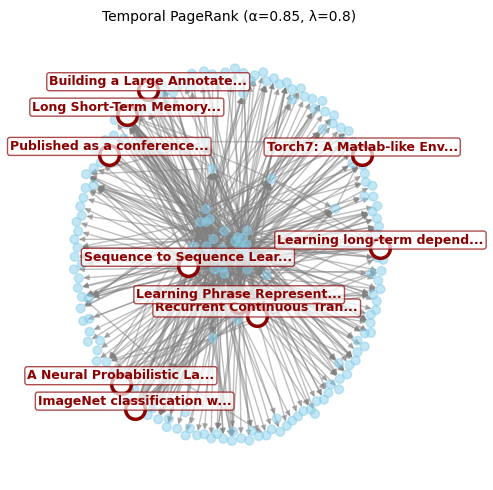

In [208]:
Analysis(G,damping_factor=0.85,temporal_decay=0.8)

#### Choosing the best hyper-parameters based on variance

In [209]:
def choose_best_hyperparameters(G, alphas, lambdas):
    variance_matrix = np.zeros((len(alphas), len(lambdas)))
    iterations_matrix = np.zeros((len(alphas), len(lambdas)))

    best_score = -1
    best_params = None

    for i, a in enumerate(alphas):
        for j, lam in enumerate(lambdas):

            PR, _, iters = PageRank(G, damping_factor=a, temporal_decay=lam)
            PR_vals = np.array(list(PR.values()))
            
            variance = np.var(PR_vals)
            variance_matrix[i, j] = variance
            iterations_matrix[i, j] = iters

            print(f"α={a}, λ={lam} → variance={variance:.6f}, iterations={iters}")

            if variance > best_score:
                best_score = variance
                best_params = (a, lam)

    print("\nBest hyperparameters:")
    print(f"  damping_factor α = {best_params[0]}")
    print(f"  temporal_decay  λ = {best_params[1]}")
    print(f"  score (variance) = {best_score:.6f}")

    return variance_matrix, iterations_matrix, best_params


In [210]:
damping_list  = [0.95, 0.85, 0.75, 0.5, 0.4, 0.2]
temporal_list = [0.1, 0.2, 0.5, 1.0]

variance_matrix , iteration_matrix ,best_params = choose_best_hyperparameters(G, damping_list, temporal_list)

PageRank converged after 308 iterations
α=0.95, λ=0.1 → variance=0.071170, iterations=308
PageRank converged after 302 iterations
α=0.95, λ=0.2 → variance=0.038183, iterations=302
PageRank converged after 287 iterations
α=0.95, λ=0.5 → variance=0.008131, iterations=287
PageRank converged after 266 iterations
α=0.95, λ=1.0 → variance=0.001030, iterations=266
PageRank converged after 105 iterations
α=0.85, λ=0.1 → variance=0.049538, iterations=105
PageRank converged after 103 iterations
α=0.85, λ=0.2 → variance=0.025287, iterations=103
PageRank converged after 98 iterations
α=0.85, λ=0.5 → variance=0.005086, iterations=98
PageRank converged after 92 iterations
α=0.85, λ=1.0 → variance=0.000762, iterations=92
PageRank converged after 62 iterations
α=0.75, λ=0.1 → variance=0.033674, iterations=62
PageRank converged after 61 iterations
α=0.75, λ=0.2 → variance=0.016696, iterations=61
PageRank converged after 58 iterations
α=0.75, λ=0.5 → variance=0.003656, iterations=58
PageRank converged a

In [211]:
def plot_heatmap(data, alphas, lambdas, title, label):
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        data,
        xticklabels=lambdas,
        yticklabels=alphas,
        annot=True,
        cmap="viridis",
        fmt=".4f" if "Variance" in title else ".0f"
    )
    plt.xlabel("Temporal Decay λ")
    plt.ylabel("Damping Factor α")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()

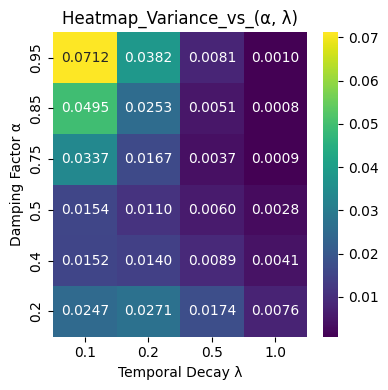

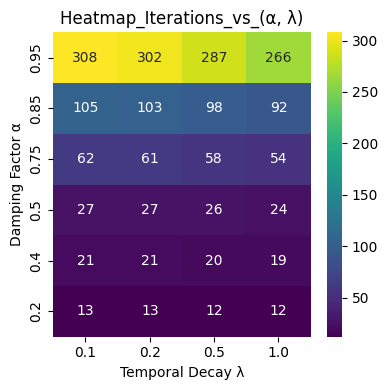

In [212]:
plot_heatmap(variance_matrix, damping_list, temporal_list,
             "Heatmap_Variance_vs_(α, λ)", "Variance")

plot_heatmap(iteration_matrix, damping_list, temporal_list,
             "Heatmap_Iterations_vs_(α, λ)", "Iterations")


PageRank converged after 266 iterations


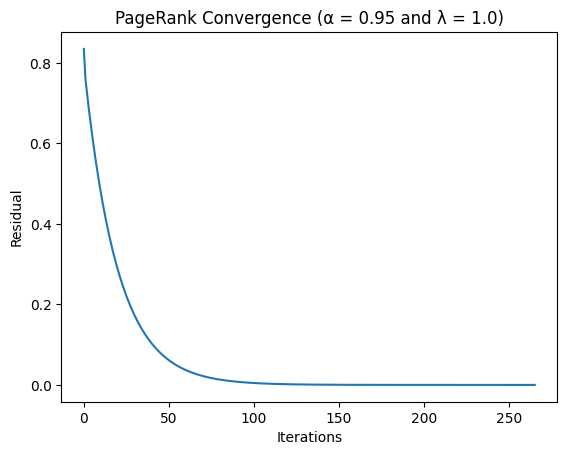


Top 10 papers by Temporal PageRank (alpha = 0.95 and λ = 1.0):
6c2b28f9 (2003) - A Neural Probabilistic Language Model... | Score: 0.2729
2e9d221c (1997) - Long Short-Term Memory... | Score: 0.2632
3449b650 (2011) - Torch7: A Matlab-like Environment for Machine Learning... | Score: 0.2248
abd1c342 (2012) - ImageNet classification with deep convolutional neural netwo... | Score: 0.2067
0b44fcbe (1993) - Building a Large Annotated Corpus of English: The Penn Treeb... | Score: 0.1897
944a1cfd (2013) - Recurrent Continuous Translation Models... | Score: 0.1699
855d0f72 (2012) - Theano: new features and speed improvements... | Score: 0.1698
d0be39ee (1994) - Learning long-term dependencies with gradient descent is dif... | Score: 0.1676
cea967b5 (2014) - Sequence to Sequence Learning with Neural Networks... | Score: 0.1570
6471fd1c (2013) - Generating Sequences With Recurrent Neural Networks... | Score: 0.1556


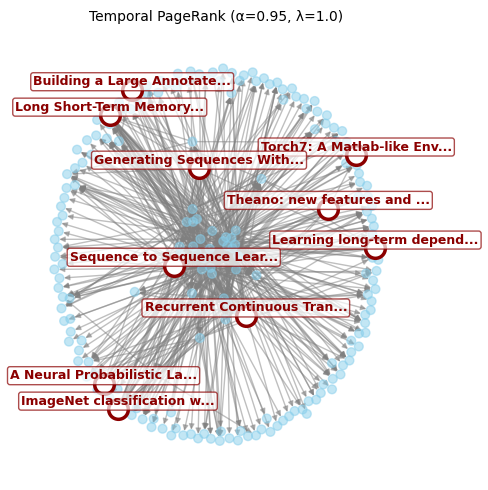

In [213]:
Analysis(G,damping_factor=0.95,temporal_decay=1.0)